In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import kpss
import statsmodels.tsa.stattools as tsa
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from arch.unitroot import PhillipsPerron
import statsmodels.tsa.arima
import seaborn as sns
from scipy import stats
import scipy.stats
import pylab
import statsmodels.api as sm

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')

  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title=serie_r.name )
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title=serie_nr.name)
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

In [65]:
def print_test_adf(y):
  resultado = adfuller(y, regression='c')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante sola')
  resultado = adfuller(y, regression='ct')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante y Tendencia Lineal')
  resultado = adfuller(y, regression='ctt')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante y Tendencia Lineal y Cuadratica')
  resultado = adfuller(y, regression='n')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Sin Contante ni Tendencia')


In [66]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Incluya término independiente pero no incluye término lineal',
              'ct':'Incluya ambos términos'
              }
    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')
        pp = PhillipsPerron(series,trend=param, **k)
        print(f'PP Estadistico: {pp.stat}')
        print(f'p-valor: {pp.pvalue}')
        print(f'numero de lags: {pp.lags}')
        print('Valor Critico:')
        for key, value in pp.critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if pp.pvalue > 0.05 else ""}estacionaria')
        print(f"PP Numero de diferenciacion estimada: {ndiffs(series, test='pp')}")

        print("*".center(60, '*'))
        print("")

In [67]:
def kpss_test(series, **kw):

    params = {'c':'Los datos son estacionarios alrededor de una constante.',
              'ct': 'Los datos son estacionarios alrededor de una tendencia.'
             }

    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')

        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        # Format Output
        print(f'KPSS Estadistico: {statistic}')
        print(f'p-valor: {p_value}')
        print(f'numero de lags: {n_lags}')
        print('Valor critico:')
        for key, value in critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if p_value < 0.05 else ""}estacionaria')
        print(f"KPSS Numero estimado de diferencias a aplicar: {ndiffs(series, test='kpss')}")

        print("*".center(60, '*'))
        print("")

In [68]:
# Función para graficar

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Año", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")

    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

In [69]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [70]:
fact_full = pd.read_excel('.\Data\Descarga_FACTURADO_CLIENTES_NB_240823.xlsx',skiprows=1)
df_fact = fact_full.groupby(by = 'Periodo', sort = True)['Suma Total'].sum().reset_index()
df_fact.rename(columns={'Periodo': 'mes', 'Suma Total': 'fact'}, inplace = True)
df_fact.set_index('mes', inplace = True)
df_fact.head()

,fact
mes,
2019-01-01,22150781.76
2019-02-01,20681481.53
2019-03-01,22316953.30
2019-04-01,22943028.41
2019-05-01,22975503.75


In [71]:
vent_full = pd.read_excel('.\Data\Descarga_VENTAS_POR_LOCALES_NB_050923.xlsx',skiprows=1)
df_vent = vent_full.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_vent.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_vent.mes = pd.to_datetime(df_vent.mes, dayfirst = True, format = '%m/%Y')
df_vent = df_vent.sort_values(by = 'mes')
df_vent.set_index('mes', inplace = True)
df_vent.head()

,ventas
mes,
2015-01-01,62633592.89
2015-02-01,62563213.35
2015-03-01,70487376.77
2015-04-01,68644186.80
2015-05-01,70835132.46


In [72]:
df_ipc = pd.read_excel('.\Data\Tabla_IPC.xlsx',skiprows=1)
df_ipc.rename(columns={'Fecha': 'fecha', 'Indice': 'ipc'}, inplace = True)
df_ipc.set_index('fecha', inplace=True)
df_ipc.head()

,ipc
fecha,
2016-12-01,100.0000
2017-01-01,101.5859
2017-02-01,103.6859
2017-03-01,106.1476
2017-04-01,108.9667


In [73]:
df_usd = pd.read_excel('.\Data\Dolar_Evolución.xlsx',skiprows=0)
df_usd = df_usd.iloc[:, 1:]
df_usd.columns = ['fecha', 'ofi', 'blue']
df_usd.set_index('fecha', inplace=True)
df_usd.head()

,ofi,blue
fecha,,
2015-01-01,8.55,13.50
2015-02-01,8.63,12.93
2015-03-01,8.72,12.52
2015-04-01,8.81,12.60
2015-05-01,8.90,12.55


In [74]:
df_retail = vent_full[(vent_full['Razón Social'] != 'GD WORK SA') & (vent_full['Rubro'] != 'SUPERMERCADO')]
df_retail = df_retail.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_retail.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_retail.mes = pd.to_datetime(df_retail.mes, dayfirst = True, format = '%m/%Y')
df_retail = df_retail.sort_values(by = 'mes')
df_retail.set_index('mes', inplace = True)
df_retail.head()

,ventas
mes,
2015-01-01,35881254.22
2015-02-01,35994300.23
2015-03-01,41635908.20
2015-04-01,41074614.00
2015-05-01,43747283.60


In [75]:
df_super = vent_full[vent_full['Rubro'] == 'SUPERMERCADO']
df_super = df_super.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_super.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_super.mes = pd.to_datetime(df_super.mes, dayfirst = True, format = '%m/%Y')
df_super = df_super.sort_values(by = 'mes')
df_super.set_index('mes', inplace = True)
df_super.head()

,ventas
mes,
2015-01-01,26752338.67
2015-02-01,26568913.12
2015-03-01,28851468.57
2015-04-01,27569572.80
2015-05-01,27087848.86


In [76]:
df_cowork = vent_full[vent_full['Razón Social'] == 'GD WORK SA']
df_cowork = df_cowork.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_cowork.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_cowork.mes = pd.to_datetime(df_cowork.mes, dayfirst = True, format = '%m/%Y')
df_cowork = df_cowork.sort_values(by = 'mes')
df_cowork.set_index('mes', inplace = True)
df_cowork.head()

,ventas
mes,
2019-01-01,824754.21
2019-02-01,983820.43
2019-03-01,1281202.80
2019-04-01,2000058.99
2019-05-01,1787994.13


In [77]:
#df_ipc.reset_index(inplace=True)
df_ipc['ipc_previo'] = df_ipc['ipc'].shift(1)
df_ipc['ipc_intermensual'] = (df_ipc['ipc'] - df_ipc['ipc_previo']) / df_ipc['ipc']
#df_ipc.set_index

In [78]:

def filtrar_serie(serie, start_date, end_date):
    serie = serie[(serie.index >= start_date) & (serie.index <= end_date)]
    return serie

In [79]:
df_vent = filtrar_serie(df_vent, '2017-01-01', '2023-08-01')
df_retail = filtrar_serie(df_retail, '2017-01-01', '2023-08-01')
df_cowork = filtrar_serie(df_cowork, '2017-01-01', '2023-08-01')
df_super = filtrar_serie(df_super, '2017-01-01', '2023-08-01')
df_usd = filtrar_serie(df_usd, '2017-01-01', '2023-08-01')

In [80]:
def corregir_usd_ipc(serie, ipc, dolar):
    corregida = serie / (1 + ipc)
    corregida = corregida / dolar
    return corregida

In [81]:
df_vent['ventas_ajustado'] = corregir_usd_ipc(df_vent['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_cowork['ventas_ajustado'] = corregir_usd_ipc(df_cowork['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_retail['ventas_ajustado'] = corregir_usd_ipc(df_retail['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_super['ventas_ajustado'] = corregir_usd_ipc(df_super['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])

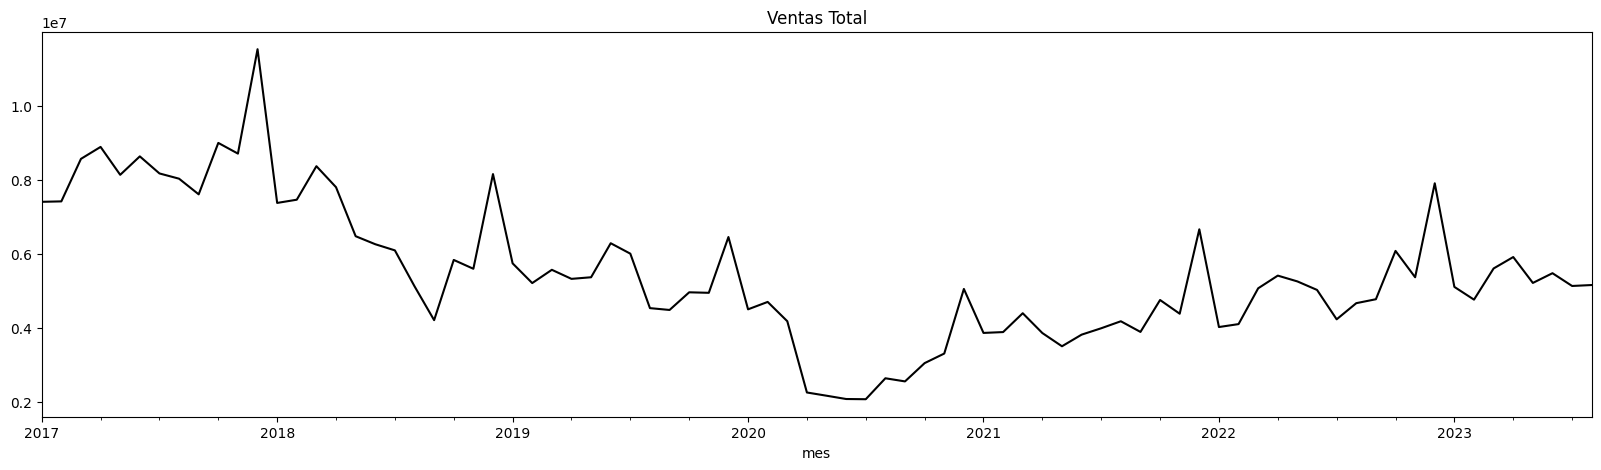

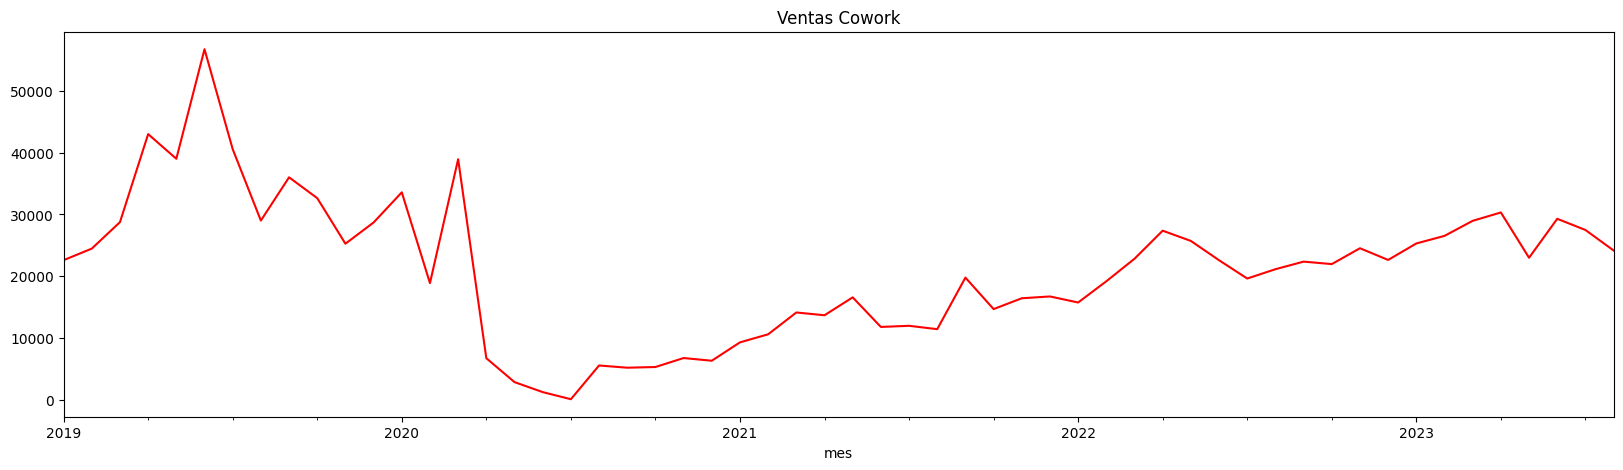

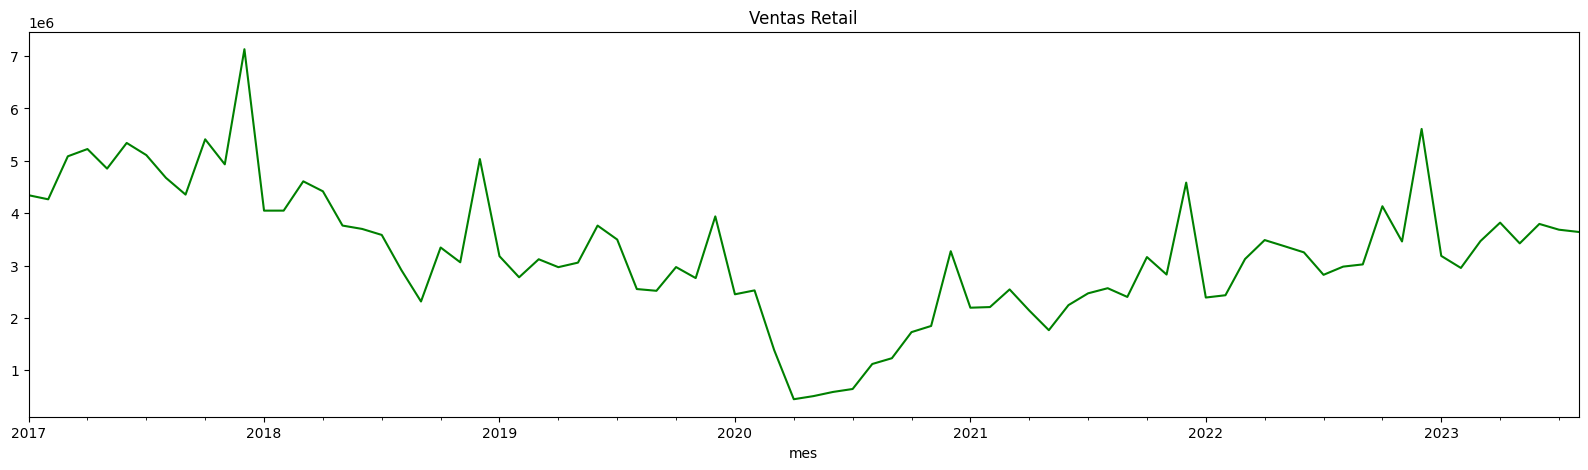

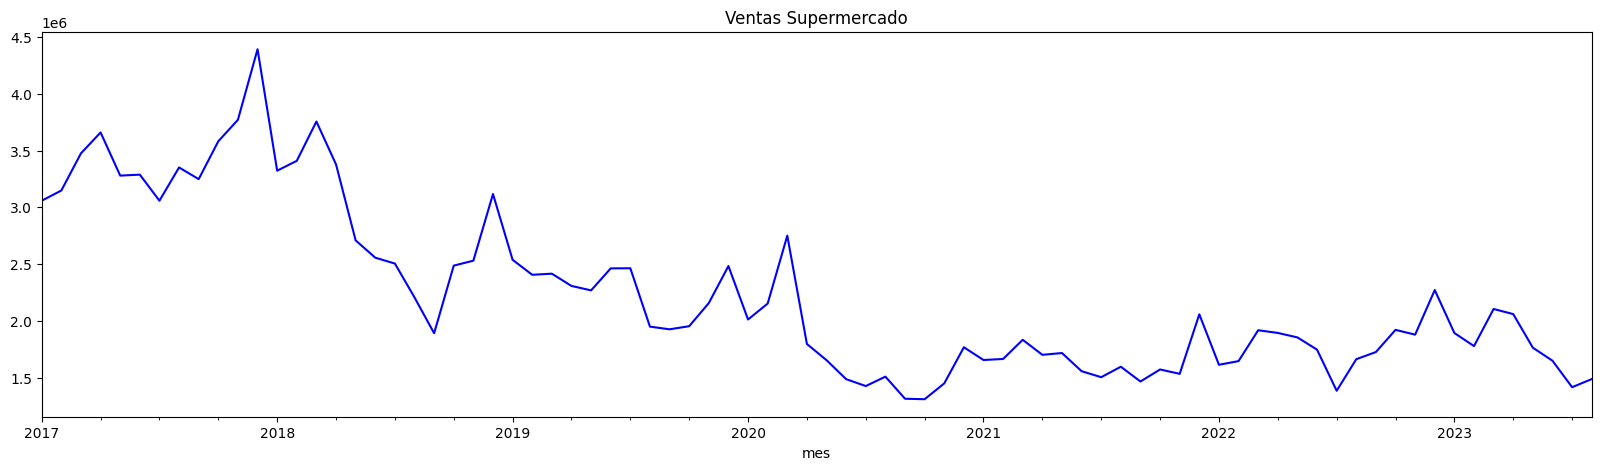

In [82]:
df_vent.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Total", color='black')
plt.show()
df_cowork.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Cowork", color='red')
plt.show()
df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail", color='green')
plt.show()
df_super.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Supermercado", color='blue')
plt.show()

Arranca analisis

Inciso 2 -  Grafico de la serie original

In [83]:
df = df_retail
color = 'green'

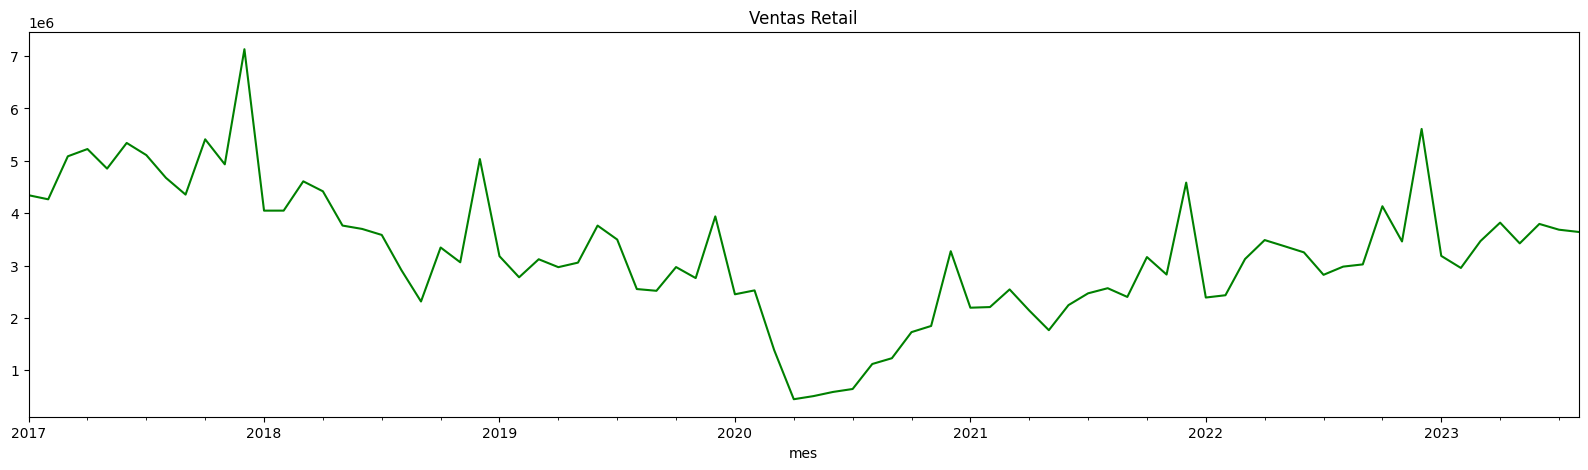

In [84]:
df.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail", color = color)
plt.show()

a simple vista no es estacionaria

Inciso 3 - Funciones de ACF y PACF

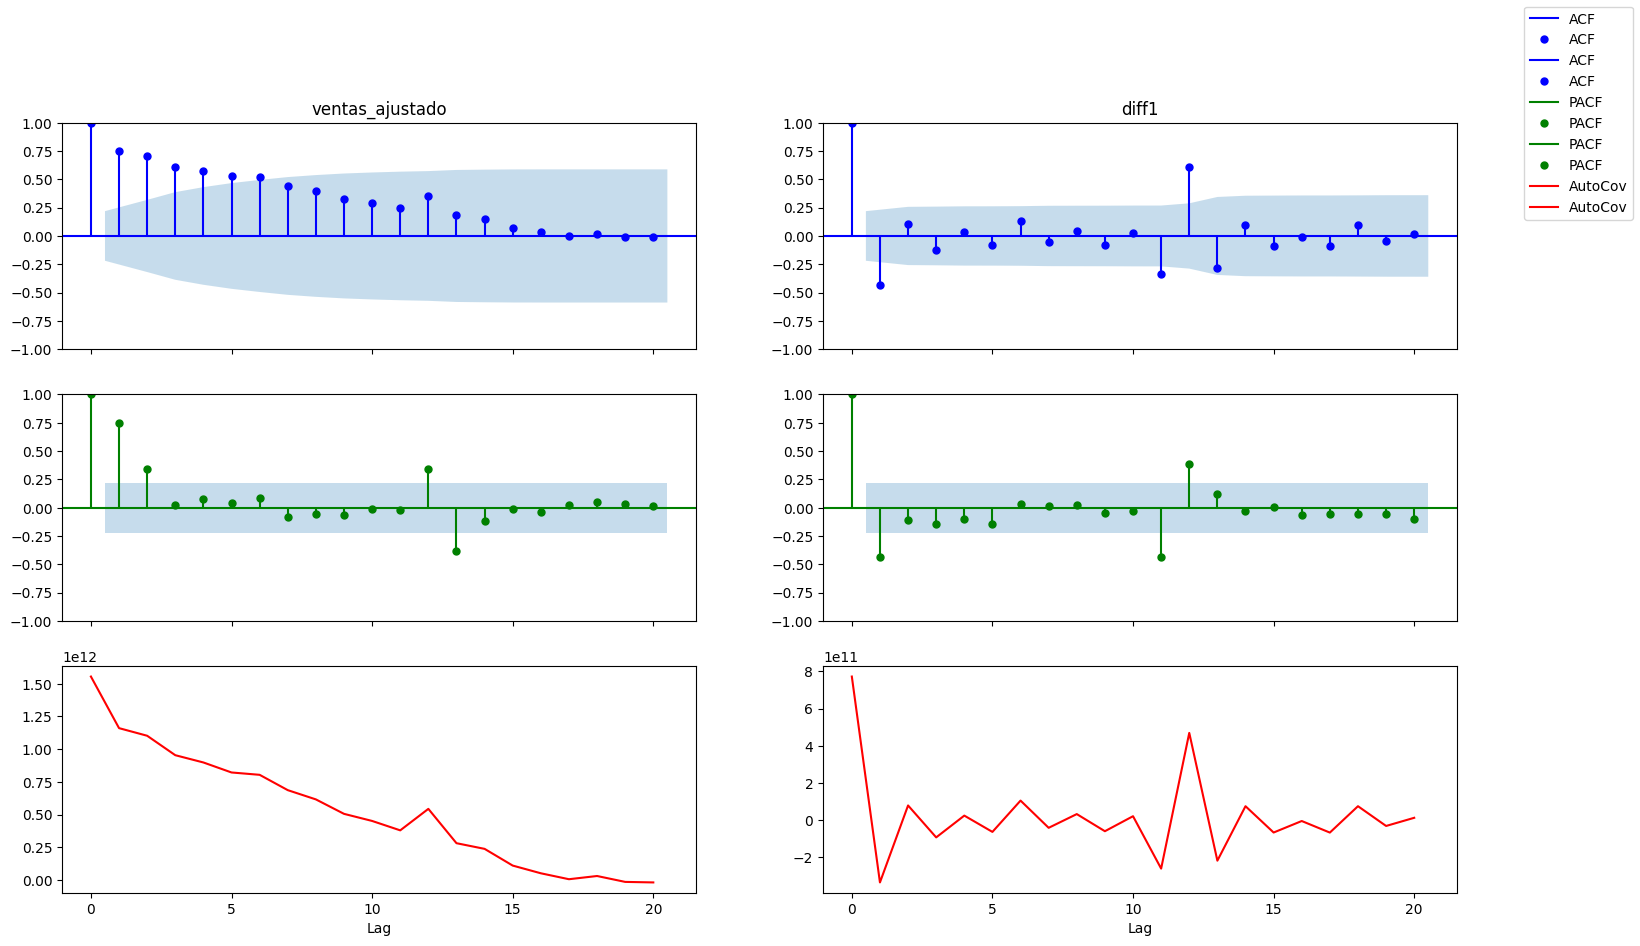

In [85]:
df['diff1'] = df.ventas_ajustado.diff(periods = 1)
df.diff1[0] = 0
autocov_autocorr(df.ventas_ajustado, df.diff1, 20)

Inciso 4 - Pruebas de raices unitarias

In [143]:
print('Dickey-Fuller')
print_test_adf(df.ventas_ajustado)
print('Phillips-Perron')
Phillips_Perron(df.ventas_ajustado)
print('KPSS')
kpss_test(df.ventas_ajustado)


Dickey-Fuller
Estadistico ADF: -2.1134 	 p-valor: 0.2391 Constante sola
Estadistico ADF: -1.5532 	 p-valor: 0.8102 Constante y Tendencia Lineal
Estadistico ADF: -2.7274 	 p-valor: 0.4387 Constante y Tendencia Lineal y Cuadratica
Estadistico ADF: -0.7234 	 p-valor: 0.4027 Sin Contante ni Tendencia
Phillips-Perron
Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -0.8730458328385109
p-valor: 0.34000625755403735
numero de lags: 12
Valor Critico:
   1% : -2.5946224226886714
   5% : -1.9448758487665276
   10% : -1.6138413966846434
Resultado: La serie es no estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -3.616186018442617
p-valor: 0.005459019683554174
numero de lags: 12
Valor Critico:
   1% : -3.5159766913976376
   5% : -2.898885703483903
   10% : -2.5866935058484217
Resultado: La serie es estac

Hasta ahora comprobamos que la serie original no es estacionaria

Pero los tests nos dan indicios de que la primer diferencia podria funcionar

arIma para todos

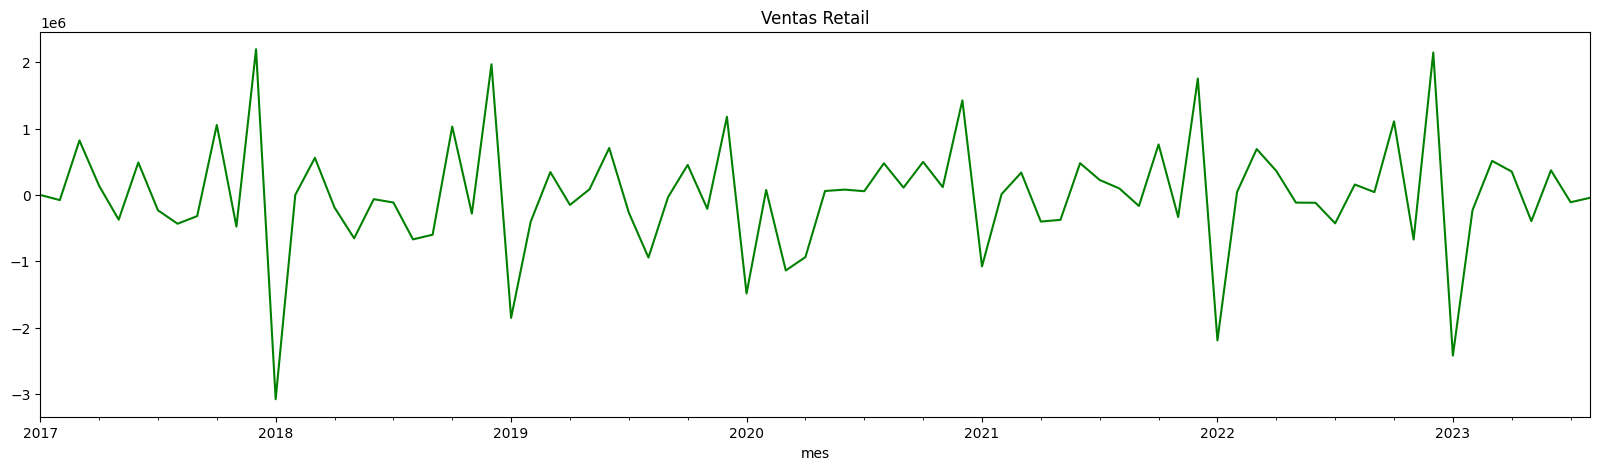

Dickey-Fuller
Estadistico ADF: -2.7607 	 p-valor: 0.0641 Constante sola
Estadistico ADF: -4.3799 	 p-valor: 0.0024 Constante y Tendencia Lineal
Estadistico ADF: -4.0866 	 p-valor: 0.0245 Constante y Tendencia Lineal y Cuadratica
Estadistico ADF: -2.6607 	 p-valor: 0.0076 Sin Contante ni Tendencia
Phillips-Perron
Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -18.042641384230386
p-valor: 5.0060673041025104e-29
numero de lags: 12
Valor Critico:
   1% : -2.5946224226886714
   5% : -1.9448758487665276
   10% : -1.6138413966846434
Resultado: La serie es estacionaria
PP Numero de diferenciacion estimada: 0
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -17.993586851895877
p-valor: 2.749141302693277e-30
numero de lags: 12
Valor Critico:
   1% : -3.5159766913976376
   5% : -2.898885703483903
   10% : -2.5866935058484217
Resultado: La serie es est

In [144]:
df.diff1.plot(figsize=(20,5), title = "Ventas Retail", color = color)
plt.show()
print('Dickey-Fuller')
print_test_adf(df.diff1)
print('Phillips-Perron')
Phillips_Perron(df.diff1)
print('KPSS')
kpss_test(df.diff1)


Inciso 5 - SARIMAX

In [308]:
sarimax = auto_arima(df.ventas_ajustado,
                     start_p=1, max_p=12,
                     start_d=1, max_d=3,
                     start_q=1, max_q=12,
                     start_P=0, max_P=12,
                     start_D=0, max_D=12,
                     start_Q=0, max_Q=12,
           seasonal=True, m=12, trace=True, stepwise=True, information_criterion='aic')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2383.102, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2391.582, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2376.702, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2378.544, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2389.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2380.998, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2378.115, Time=0.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2377.113, Time=0.26 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2377.577, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2379.077, Time=0.55 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2382.804, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2378.722, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2378.813, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2377.678, Time=0.08 sec
 ARIMA(2,1,1)(1,0,0

In [145]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   80
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1184.329
Date:                            Sat, 04 Nov 2023   AIC                           2374.658
Time:                                    13:16:05   BIC                           2381.766
Sample:                                01-01-2017   HQIC                          2377.505
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2898      0.064     -4.560      0.000      -0.414      -0.165
ar.S.L12       0.2599      0.050      5.210      0.000       0.162       0.358
sigma2      6.422e+11   1.57e-14    4.1e+25      0.000    6.42e+11    6.42e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                71.02
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.79
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Inciso 6 - Predecir

In [92]:
# Separacion Train/Test
train = df.iloc[:round(len(df)*.80)].ventas_ajustado
test = df.iloc[round(len(df)*.80):].ventas_ajustado

In [93]:
modelo_sarima = SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12))
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    ventas_ajustado   No. Observations:                   64
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -946.511
Date:                            Sat, 04 Nov 2023   AIC                           1899.022
Time:                                    12:54:21   BIC                           1905.452
Sample:                                01-01-2017   HQIC                          1901.551
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.075     -3.627      0.000      -0.422      -0.126
ar.S.L12       0.1545      0.056   

Inciso 7 - Probar otros modelos

In [267]:
modelos_alt = []
modelos_alt.append(SARIMAX(train, order=(1,0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,1,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,1,12)).fit())

modelos_alt.append(SARIMAX(train, order=((1,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,0), seasonal_order=(1,0,0,12)).fit())

modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())

modelos_alt_nombres = ['AR 1','MA 1','ARMA 1-1','AR 1,2','MA 1,2','AR 1,2,12','MA 1,2,12',
                       'ARIMA 1-1-0','ARIMA 0-1-1','ARIMA 1-1-1','ARIMA 1,2-1-0','ARIMA 0-1-1,2','ARIMA 1,2,12-1-0','ARIMA 0-1-1,2,12',
                       'SARIMA 1-1-0 Season AR 1','SARIMA 1-1-0 Season MA 1','SARIMA 1-1-0 Season ARMA 1-1',
                       'AR 1,12','ARIMA 1,12-1-0',
                       'MA 1,12','ARIMA 0-1-1,12',
                       'ARIMA 0-0-0 Season AR 1',
                       'AR 12','MA 12','ARIMA 12-1-0','ARIMA 0-1-12']

In [335]:
i = 0
for mod in modelos_alt:
    print(f'Modelo {i}-Akaike: {round(mod.aic,4)}-\t{modelos_alt_nombres[i]}')
    i += 1

print('\n\nModelos Sospechosos')

# sus = [5,12,17]
# for i in sus:
#     print(f'Modelo {i}-Akaike: {round(modelos_alt[i].aic,0)}-\t{modelos_alt_nombres[i]}')
#     print(modelos_alt[i].params)

Modelo 0-Akaike: 1939.3972-	AR 1
Modelo 1-Akaike: 2072.397-	MA 1
Modelo 2-Akaike: 1929.4622-	ARMA 1-1
Modelo 3-Akaike: 1930.729-	AR 1,2
Modelo 4-Akaike: 2057.2077-	MA 1,2
Modelo 5-Akaike: 8.0-	AR 1,2,12
Modelo 6-Akaike: 2028.2274-	MA 1,2,12
Modelo 7-Akaike: 1898.9437-	ARIMA 1-1-0
Modelo 8-Akaike: 1899.373-	ARIMA 0-1-1
Modelo 9-Akaike: 1900.9254-	ARIMA 1-1-1
Modelo 10-Akaike: 1900.967-	ARIMA 1,2-1-0
Modelo 11-Akaike: 1901.1304-	ARIMA 0-1-1,2
Modelo 12-Akaike: 51.0803-	ARIMA 1,2,12-1-0
Modelo 13-Akaike: 1902.9348-	ARIMA 0-1-1,2,12
Modelo 14-Akaike: 1899.0221-	SARIMA 1-1-0 Season AR 1
Modelo 15-Akaike: 1899.1972-	SARIMA 1-1-0 Season MA 1
Modelo 16-Akaike: 1900.5622-	SARIMA 1-1-0 Season ARMA 1-1
Modelo 17-Akaike: 6.0-	AR 1,12
Modelo 18-Akaike: 1938.6846-	ARIMA 1,12-1-0
Modelo 19-Akaike: 2045.4012-	MA 1,12
Modelo 20-Akaike: 1900.9043-	ARIMA 0-1-1,12
Modelo 21-Akaike: 2025.9619-	ARIMA 0-0-0 Season AR 1
Modelo 22-Akaike: 2025.9619-	AR 12
Modelo 23-Akaike: 2078.8583-	MA 12
Modelo 24-Akaike: 19

In [300]:
modelo_pick = modelos_alt[25]
print(modelo_pick.summary())


                                SARIMAX Results                                
Dep. Variable:         ventas_ajustado   No. Observations:                   64
Model:             SARIMAX(0, 1, [12])   Log Likelihood                -950.372
Date:                 Sat, 04 Nov 2023   AIC                           1904.744
Time:                         14:28:15   BIC                           1909.030
Sample:                     01-01-2017   HQIC                          1906.429
                          - 04-01-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L12         0.2075      0.038      5.518      0.000       0.134       0.281
sigma2      6.077e+11    2.4e-14   2.54e+25      0.000    6.08e+11    6.08e+11
Ljung-Box (L1) (Q):                   9.31  

Dados los resultados finales de los tests, principalmente el AIC porque es facil de evaluar a simple vista

Concluimos que el mejor modelo es el que propuso AutoARIMA (Un ARIMA 1-1-0 con Season AR 1 (12))

Inciso 8 - Analisis de Diagnostico

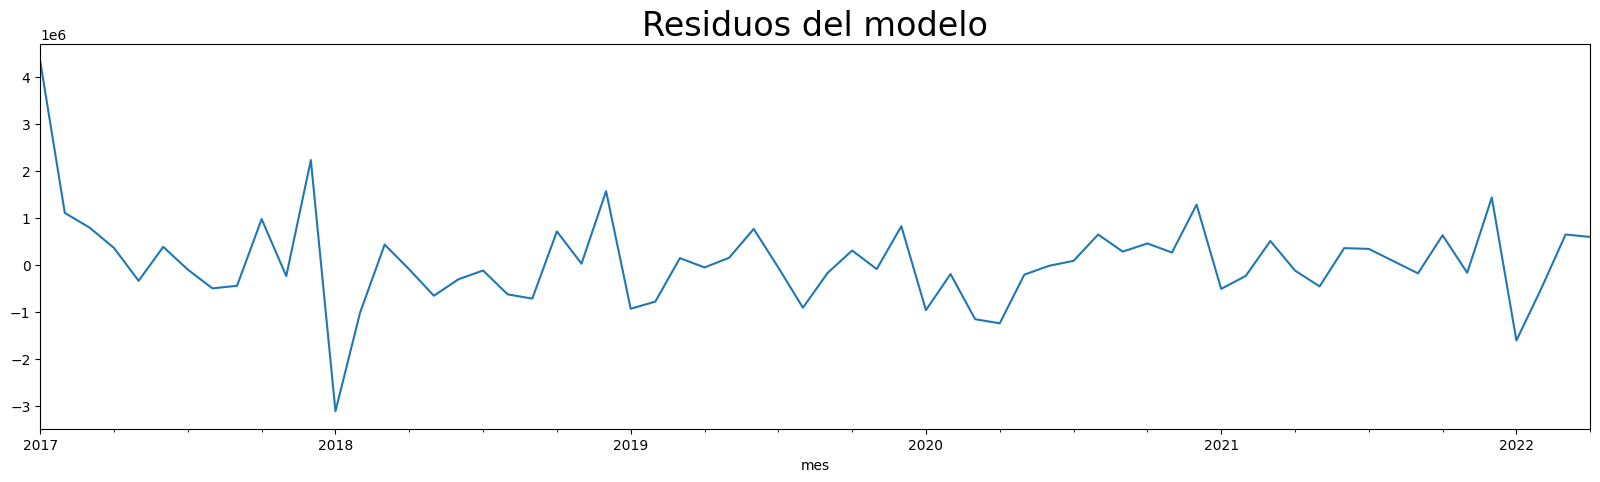

In [309]:
modelo_sarima.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

Text(0.5, 1.0, 'Histograma de los residuos del modelo')

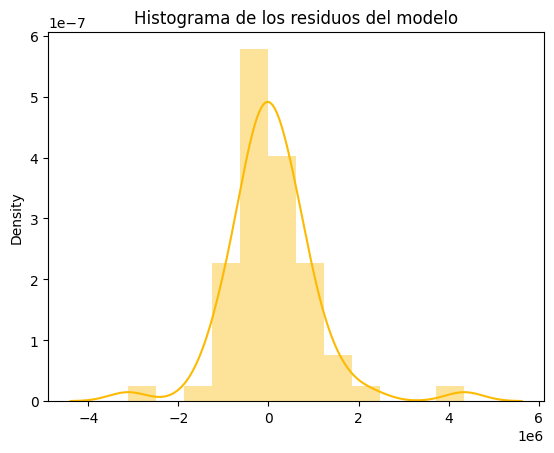

In [310]:
sns.distplot(modelo_sarima.resid,bins=12,color='#fcba03')
plt.title('Histograma de los residuos del modelo')

In [312]:
stats.shapiro(modelo_sarima.resid)

ShapiroResult(statistic=0.8977938890457153, pvalue=6.614313315367326e-05)

!!FALTA PROBAR BREUSCH PAGAN!!

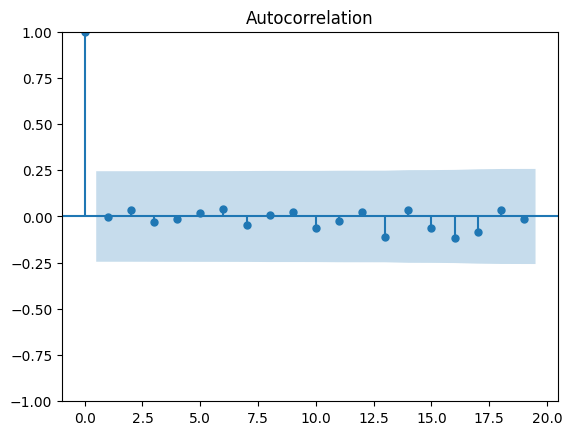

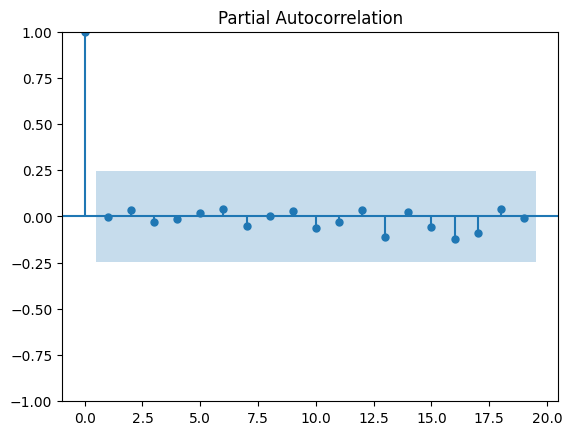

In [318]:
plot_acf(modelo_sarima.resid);
plot_pacf(modelo_sarima.resid);

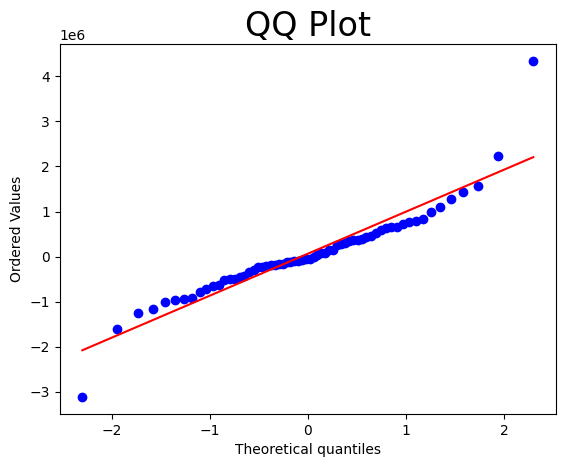

In [319]:
scipy.stats.probplot(modelo_sarima.resid, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

In [327]:
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(modelo_sarima.resid, lags=10)

In [328]:
Incorr_residuos_modelo

,lb_stat,lb_pvalue
1,0.001153,0.972917
2,0.077393,0.962043
3,0.138627,0.986830
4,0.153808,0.997190
5,0.181219,0.999303
6,0.285200,0.999566
7,0.458458,0.999585
8,0.460714,0.999902
9,0.504865,0.999968
10,0.798064,0.999939


Text(0, 0.5, 'P-valores ')

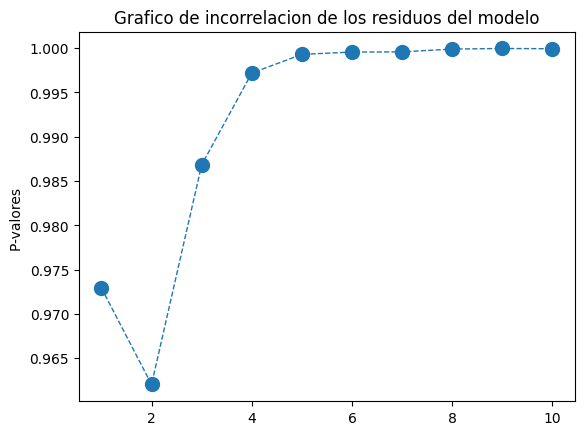

In [329]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo")
plt.ylabel("P-valores ")

La hipotesis nula es que los datos son independientes
vemos que generalmente no rechazan

aprueba el test

notamos que los residuos son ruido blanco, lo cual es favorable

pero que su distribucion no es normal, lo que reduce la validez del modelo para efectuar predicciones

Inciso 9 - Pronosticar

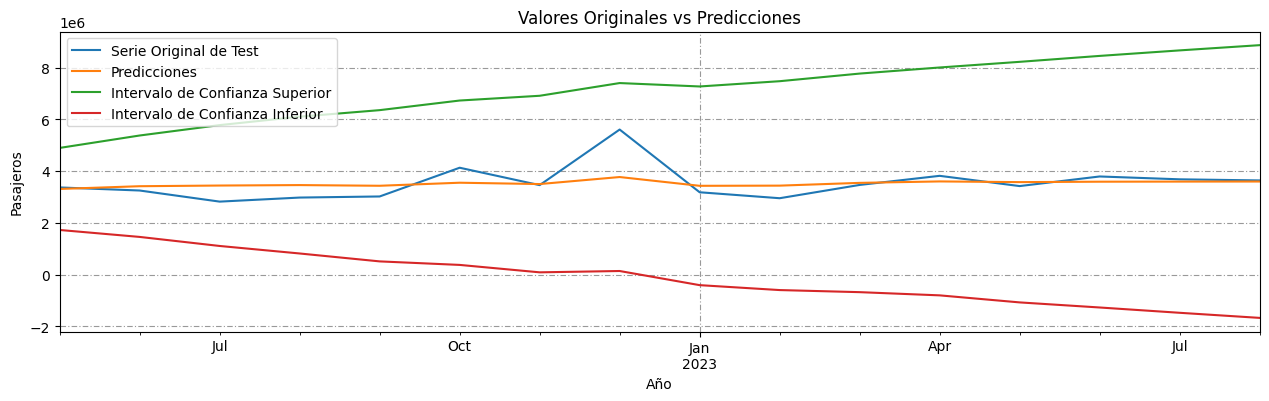

In [ ]:
predicciones_sarima = modelo_sarima.get_forecast(16)
graficar_pred(test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int())

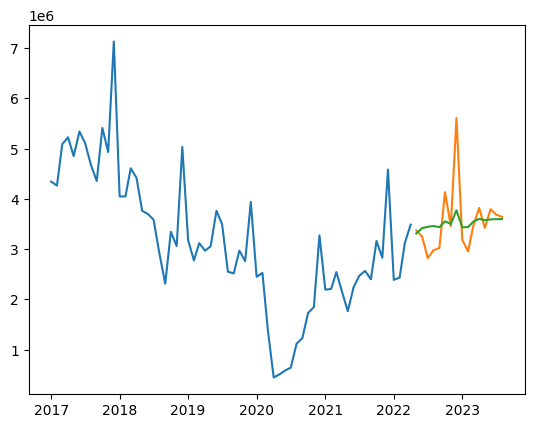

In [ ]:
plt.plot(train)
plt.plot(test)
plt.plot(predicciones_sarima.predicted_mean)

In [336]:
evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

MSE: 309256970025.1567
MAE: 357020.72522819834
RMSE: 556108.7753534884
MAPE: 0.0951


Inciso 10 - VAR

In [374]:
serieVAR = pd.concat([df_retail.ventas_ajustado, df_super.ventas_ajustado, df_cowork.ventas_ajustado], axis=1)
serieVAR.columns = ['retail','super','cowork']
serieVAR.dropna(inplace=True)
serieVAR.head()


,retail,super,cowork
mes,,,
2019-01-01,3.179199e+06,2.537927e+06,22594.409792
2019-02-01,2.776850e+06,2.406029e+06,24468.251408
2019-03-01,3.120984e+06,2.415744e+06,28754.498688
2019-04-01,2.970091e+06,2.307941e+06,43013.413042
2019-05-01,3.056532e+06,2.268776e+06,39021.383998


In [375]:
split = .8
train = serieVAR.iloc[:round(len(serieVAR)*split)]
test = serieVAR.iloc[round(len(serieVAR)*split):]

In [360]:
from statsmodels.tsa.stattools import grangercausalitytests

In [361]:
# P-valores menores al nivel de significancia (0.05) implica que la hipotesis nula (X no causa Y) puede rechazarse.
# testgr: Es el tipo de prueba que se utilizará para evaluar la causalidad de Granger. Por defecto, se utiliza 'ssr_chi2test', que es una prueba basada en chi-cuadrado,

def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):


    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# se agrega '_x' al final de los nombres de las columnas para indicar que son las variables "causantes" y '_y' al final de los nombres de las filas para indicar que son las variables "afectadas".

In [376]:
testgr = 'ssr_chi2test'
grangers_causation_matrix(train, variables = train.columns, maxlag=10)

,retail_x,super_x,cowork_x
retail_y,9.999999e-01,3.779729e-13,1.282611e-01
super_y,2.015927e-08,1.000000e+00,8.569843e-12
cowork_y,2.975046e-14,2.968498e-07,1.000000e+00


En base a los resultados del test de granger, vemos que no se rechaza la hipotesis nula

es decir que no podemos afirmar que haya una relacion de causalidad entre las variables elegidas

Esto quiere decir que nuestros datos no son un buen candidato para el modelo VAR

Inciso 11 - Impulso-Respuesta

No aplica